## Linked De Bruijn Graphs in Pyfrost

De Bruijn graphs are easily constructed by simply k-merizing reads or genome assemblies. One disadvantage of De Bruijn graphs is that any longer range information is lost. A 150bp read contains much more information about which nodes should be connected than only available from its k-mers (k << 150). 

To alleviate this limitation, we add "links" on top of a De Bruin graph. Links are annotations on a subset of k-mers in a De Bruijn graph that help navigate the graph, using connectivity information from reads or genome assemblies. For a full description of links, please read the [paper by Turner *et al*](https://academic.oup.com/bioinformatics/article/34/15/2556/4938484). 

### Creating and storing links

In Pyfrost, all link related functionality is available in the `pyfrost.links` subpackage. Links are stored in a `LinkDB`, and currently the only option is to store and load all links simultaneously in memory with a `MemLinkDB`. To demonstrate how addings links on a graph, let's first download a few genome assemblies, and construct the graph.

In [1]:
from pathlib import Path
import ncbi_genome_download as ngd

import pyfrost

Path("_data").mkdir(exist_ok=True)

if not Path("_data/human_readable/refseq/bacteria/Citrobacter").is_dir():
    ngd.download(groups="bacteria", assembly_accessions="GCF_001037585.2,GCF_014337275.1", human_readable=True, file_formats="fasta", output="_data")

In [2]:
%%bash
# Let's build a graph from both the assemblies and the read data using the Bifrost CLI tool
ls -1 _data/human_readable/refseq/bacteria/*/*/*/*.fna.gz > _data/ref_list.txt
Bifrost build -r _data/ref_list.txt -s _data/Citr_sp_BIDMC108.subsampled.concat.fq.gz -c -i -d -o _data/combined_graph

In [3]:
g = pyfrost.load('_data/combined_graph.gfa')

#### Creating links from assemblies

Links can be constructed from full genome assemblies. If you've read the above paper you might know that links are essentially a collection of junction choices at nodes with multiple outgoing edges. When the graph is constructed from multiple assemblies or read data sets, a branch in the graph could mean that one color diverges from another. Thus, at such a node, we could store a link indicating the junction taken. If you take the subgraphs of each individual color, however, that branch might appear as a node with a single outgoing edge. In such a case, we don't necessarily need to store a link because each indivudual color only has a single outgoing edge. Therefore, I'd recommend associating a `LinkDB` with a specific color of the graph, by specifying the `color` parameter to the constructor, or setting the `color` attribute. Associating the `LinkDB` with a specific color ensures links are only added at branches where there are multiple outgoing edges both consistent with the given color.

In [4]:
# Inspect the color IDs in the graph
color_map = {}
for c, name in enumerate(g.graph['color_names']):
    print(c, name)
    color_map[name] = c

0 _data/Citr_sp_BIDMC108.subsampled.concat.fq.gz
1 _data/human_readable/refseq/bacteria/Citrobacter/freundii/MGH279/GCF_014337275.1_ASM1433727v1_genomic.fna.gz
2 _data/human_readable/refseq/bacteria/Citrobacter/sp./BIDMC108/GCF_001037585.2_ASM103758v2_genomic.fna.gz


To create links from a FASTA file, use `pyfrost.links.add_links_from_fasta`. We specify the graph, the `MemLinkDB`, the path to the FASTA file, and an `annotator_cls`, which in this case is `pyfrost.links.RefLinkAnnotator` because the source is a genome assembly. We also want to add links from both strands of each contig in the FASTA file.

In [5]:
import skbio
from pyfrost import links

BIDMC108_PATH = "_data/human_readable/refseq/bacteria/Citrobacter/sp./BIDMC108/GCF_001037585.2_ASM103758v2_genomic.fna.gz"

bidmc108_links = links.MemLinkDB(color_map[BIDMC108_PATH])
links.add_links_from_fasta(g, bidmc108_links, BIDMC108_PATH, annotator_cls=links.RefLinkAnnotator, both_strands=True)

print("Number of k-mers with links:", len(bidmc108_links))

Number of k-mers with links: 4711


#### Creating links from reads

Links can also be created from (paired) read data sets. In this case we use `pyfrost.links.add_links_from_fastq`.

In [6]:
BIDMC108_READS = [
    "_data/Citr_sp_BIDMC108.subsampled.1.fq.gz",
    "_data/Citr_sp_BIDMC108.subsampled.2.fq.gz",
]

COLOR_NAME = "_data/Citr_sp_BIDMC108.subsampled.concat.fq.gz"

bidmc108_read_links = links.MemLinkDB(color_map[COLOR_NAME])
links.add_links_from_fastq(g, bidmc108_read_links, BIDMC108_READS)

print("Number of k-mers with links:", len(bidmc108_read_links))

Number of k-mers with links: 642


If you have paired reads, the individual reads are considered independently by default, and the pairing information is discarded. Read pairs, however, can provide even longer range connectivity information as they originate from the same DNA fragment, and it would be valueable to utilize this information. Pyfrost's solution is to have a "two-pass mode": first we construct a temporary `LinkDB`, storing links created from each read independently. Then we perform another pass, but now for each read pair trying to find a path through the graph that connects the end k-mer of the first read in the pair to the start k-mer of the second read in the pair, with support from links created in the first pass. If such path can be found without ambiguities, the links created from the first read in the pair are extended with the found path, and with the links created from the second read.

In [7]:
bidmc108_read_pairs = links.MemLinkDB(color_map[COLOR_NAME])

with open("_data/mapping_results.tsv", "w") as o:
    links.add_links_from_fastq(g, bidmc108_read_pairs, BIDMC108_READS, twopass=True, mapping_results_out=o)

The above example enables the two-pass mode by setting `twopass=True`. We also enable another feature, logging the mapping results to a file. This is useful for debugging purposes: it logs a lot of data for each read (pair), indicating matching k-mers, whether a path could be found, etc. This logging slows down the whole process a lot, so only use it if you need to debug a result.

#### Saving links to disk

Links can be stored on disk using the `save()` method. To load links from disk use `MemLinkDB.from_file(path)`.

In [8]:
bidmc108_links.save("_data/bidmc108_ref.links")
bidmc108_read_pairs.save("_data/bidmc108_reads.links")

### Navigating with links

#### Inspecting links

Links are associated with the k-mer before a branch, i.e., the tail k-mer of any unitig. To obtain the junction tree for a given tail k-mer, use the Python indexing syntax:

In [9]:
kmer = next(iter(bidmc108_read_pairs))

jt = bidmc108_read_pairs[kmer]
print(kmer, jt)

CATGCCTGATGGCGCTACGCTTATCAGGCCT <JunctionTreeNode parent=- count=1 children=[G]>


Links associated with a k-mer are stored in a Junction Tree (see paper for details). A junction tree represents one or more links, and stores coverage information. 

To obtain all links represented by the junction tree, use `pyfrost.links.jt.get_all_links`.

In [10]:
list(links.jt.get_all_links(jt))

[Link(node=<JunctionTreeNode parent=G count=1 children=[]>, choices=b'GGG', coverage=array([1, 1, 1], dtype=uint16))]

In this case, the junction tree only represents a single `Link`, but thanks to the reads we now know to take the 'G' path at the next three junctions if traversing through the unitig ending with k-mer `CATGCCTGATGGCGCTACGCTTATCAGGCCT`. Because our read data set is heavily subsampled (<1x coverage of BIDMC108's genome), the coverage is just one.

We can visualize the graph and the junction choices using `dot`. Pyfrost provides some convient wrappers to obtain the neighborhood around a one or more k-mers, and display the resulting subgraph in a notebook.

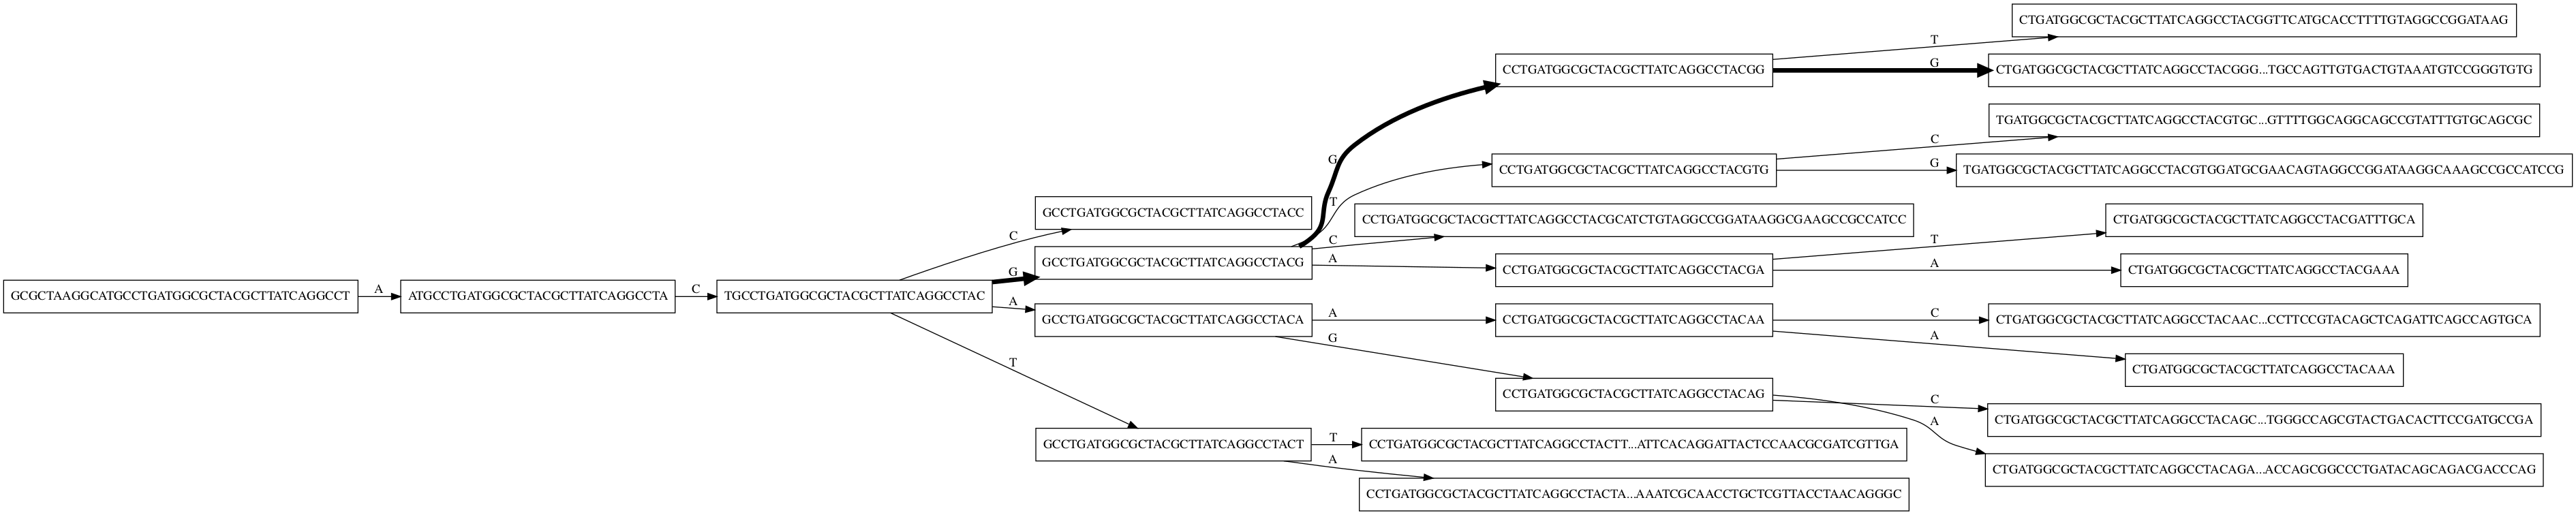

In [11]:
from pyfrost.viz.dot import display_graph, to_pydot

link = next(iter(links.jt.get_all_links(jt)))

neighborhood = pyfrost.get_neighborhood(g, kmer, radius=5, both_directions=False, ext_colors={color_map[COLOR_NAME]})
dot = to_pydot(neighborhood)

for (u, v), cov in links.link_junction_edges(g, kmer, link):
    edge = dot.get_edge(str(u), str(v))[0]
    edge.set_penwidth(5)

display_graph(dot)

As you can see, the graph becomes quite complex, but the reads enable us to connect the first node on the left to a quite distant node on the right.

#### Building link supported paths

If you don't want to deal with all links manually, and just want to build a path supported by links, use `pyfrost.links.link_supported_path_from`. This function tries to build a path as long as possible, and will pickup links along the way. It halts when there's ambiguity in the links, or when links are not available and we encounter a branch in the graph. It returns an iterator yielding nodes in the path (it does **not** yield the start node). The function accepts a parameter `distance_limit` to halt after a maximum number of k-mers traversed, and can optionally halt when reaching a specific node (or nodes) by using the parameter `stop_unitig`. If you want to use a custom stopping condition, use this function as part of a `for`-loop and break when the condition is met.

In [19]:
start_node = g.find(kmer)['head']  # the k-mer with associated link is a tail k-mer of a unitig, and thus not a "node" in our NetworkX graph
path = list(links.link_supported_path_from(g, bidmc108_read_pairs, start_node))

print([start_node, *path])
print()
print(pyfrost.path_sequence(g, [start_node, *path]))

[<Kmer 'GCGCTAAGGCATGCCTGATGGCGCTACGCTT'>, <Kmer 'ATGCCTGATGGCGCTACGCTTATCAGGCCTA'>, <Kmer 'TGCCTGATGGCGCTACGCTTATCAGGCCTAC'>, <Kmer 'GCCTGATGGCGCTACGCTTATCAGGCCTACG'>, <Kmer 'CCTGATGGCGCTACGCTTATCAGGCCTACGG'>, <Kmer 'CTGATGGCGCTACGCTTATCAGGCCTACGGG'>]

GCGCTAAGGCATGCCTGATGGCGCTACGCTTATCAGGCCTACGGGCGGGTGCCGTTGTAGGCCGGATAAGGCATTAATGCCGCCACCCAGCAAAAGCGCTTACCTTAACGATAAGTGCTTTGGTGTTCAAGCCTTGAGCGATCAGGCTATGCCAGTTGTGACTGTAAATGTCCGGGTGTG


Pyfrost's `link_supported_path_from` is a pretty simple wrapper around a class `pyfrost.links.NavigationEngine`, which gives you more control and access over the picked up links. Advanced users are welcome to checkout the source code.